In [2]:
from backtesting.test import EURUSD
from backtesting.test import SMA
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting import Backtest
import backtesting
import pandas as pd
%time
def SMA(values, n):
    return pd.Series(values).rolling(n).mean()


class SmaCross(Strategy):
    
    n1 = 10
    n2 = 20
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()

        elif crossover(self.sma2, self.sma1):
            self.sell()


bt = Backtest(EURUSD, SmaCross, cash=1000, commission=.002)
bt.run()
bt.plot()

Wall time: 0 ns


In [3]:
##optimize
%time

stats = bt.optimize(n1=range(5, 30, 5),
                    n2=range(10, 70, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda p: p.n1 < p.n2)
stats
bt.plot()

Wall time: 0 ns


In [7]:
import pandas as pd
from backtesting.lib import SignalStrategy, TrailingStrategy


class SmaCross(SignalStrategy,
               TrailingStrategy):
    n1 = 10
    n2 = 20
    
    def init(self):
        super().init()
        
        sma1 = self.I(SMA, self.data.Close, self.n1)
        sma2 = self.I(SMA, self.data.Close, self.n2)
        
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        
        self.set_signal(signal)
        
        self.set_trailing_sl(4)
        
from backtesting import Backtest
from backtesting.test import GOOG

bt = Backtest(GOOG, SmaCross, commission=.002)

bt.run()
bt.plot()        

In [8]:
import pandas as pd


def SMA(array, n):
    return pd.Series(array).rolling(n).mean()


def RSI(array, n):
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)


from backtesting import Strategy, Backtest
from backtesting.lib import resample_apply


class System(Strategy):
    d_rsi = 30  # Daily RSI lookback periods
    w_rsi = 30  # Weekly
    level = 70
    
    def init(self):
        # Compute moving averages the strategy demands
        self.ma10 = self.I(SMA, self.data.Close, 10)
        self.ma20 = self.I(SMA, self.data.Close, 20)
        self.ma50 = self.I(SMA, self.data.Close, 50)
        self.ma100 = self.I(SMA, self.data.Close, 100)
        
        # Compute daily RSI(30)
        self.daily_rsi = self.I(RSI, self.data.Close, self.d_rsi)
        
        # To construct weekly RSI, we can use `resample_apply()`
        # helper function from the library
        self.weekly_rsi = resample_apply(
            'W-FRI', RSI, self.data.Close, self.w_rsi)
        
        
    def next(self):
        price = self.data.Close[-1]
        
        # If we don't already have a position, and
        # if all conditions are satisfied, enter long.
        if (not self.position and
            self.daily_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.daily_rsi[-1] and
            self.ma10[-1] > self.ma20[-1] > self.ma50[-1] > self.ma100[-1] and
            price > self.ma10[-1]):
            
            # Buy at market price on next open, but do
            # set 8% fixed stop loss.
            self.buy(sl=.92 * price)
        
        # If the price closes 2% or more below 10-day MA
        # close the position, if any.
        elif price < .98 * self.ma10[-1]:
            self.position.close()
            
from backtesting.test import GOOG

backtest = Backtest(GOOG, System, commission=.002)
backtest.run()      


Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure [%]                          2.59949
Equity Final [$]                      10032.7
Equity Peak [$]                       11012.5
Return [%]                            0.32725
Buy & Hold Return [%]                 703.458
Max. Drawdown [%]                    -10.1606
Avg. Drawdown [%]                    -6.57636
Max. Drawdown Duration     2653 days 00:00:00
Avg. Drawdown Duration      940 days 00:00:00
# Trades                                    4
Win Rate [%]                               25
Best Trade [%]                        9.51454
Worst Trade [%]                      -4.46166
Avg. Trade [%]                       0.210738
Max. Trade Duration          35 days 00:00:00
Avg. Trade Duration          21 days 00:00:00
Expectancy [%]                        4.54653
SQN                                 0.0261005
Sharpe Ratio                      

In [9]:
%%time

backtest.optimize(d_rsi=range(10, 35, 5),
                  w_rsi=range(10, 35, 5),
                  level=range(30, 80, 10))

Wall time: 10.2 s


Start                                    2004-08-19 00:00:00
End                                      2013-03-01 00:00:00
Duration                                  3116 days 00:00:00
Exposure [%]                                         20.5071
Equity Final [$]                                     23090.8
Equity Peak [$]                                      23686.3
Return [%]                                           130.908
Buy & Hold Return [%]                                703.458
Max. Drawdown [%]                                   -19.2731
Avg. Drawdown [%]                                   -3.84673
Max. Drawdown Duration                     778 days 00:00:00
Avg. Drawdown Duration                      97 days 00:00:00
# Trades                                                  22
Win Rate [%]                                         63.6364
Best Trade [%]                                       25.0905
Worst Trade [%]                                     -6.21969
Avg. Trade [%]          

In [10]:
backtest.plot()

In [14]:
from backtesting.test import SMA

from backtesting import Strategy
from backtesting.lib import crossover


class Sma4Cross(Strategy):
    n1 = 50
    n2 = 100
    n_enter = 20
    n_exit = 10
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)
        
    def next(self):
        
        if not self.position:
            
            # On upwards trend, if price closes above
            # "entry" MA, go long
            
            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1 > self.sma2:
                if crossover(self.data.Close, self.sma_enter):
                    self.buy()
                    
            # On downwards trend, if price closes below
            # "entry" MA, go short
            
            else:
                if crossover(self.sma_enter, self.data.Close):
                    self.sell()
        
        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position
        
        else:
            if (self.position.is_long and
                crossover(self.sma_exit, self.data.Close)
                or
                self.position.is_short and
                crossover(self.data.Close, self.sma_exit)):
                
                self.position.close()

In [16]:
%%time 

from backtesting import Backtest
from backtesting.test import GOOG


backtest = Backtest(GOOG, Sma4Cross, commission=.002)

stats, heatmap = backtest.optimize(
    n1=range(10, 110, 10),
    n2=range(20, 210, 20),
    n_enter=range(15, 35, 5),
    n_exit=range(10, 25, 5),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    return_heatmap=True)

C:\Users\Realm\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Searching best of 486 configurations.
  


Wall time: 31.6 s


In [18]:
heatmap
heatmap.sort_values().iloc[-3:]

n1  n2   n_enter  n_exit
40  60   25       15        21137.844693
50  120  20       15        22012.499715
40  160  20       15        22644.287967
dtype: float64

In [19]:
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
hm

n2,40,60,80,100,120,140,160,180,200
n1,,,,,,,,,
20,8742.766019,10020.289811,9877.111350,11005.879439,12832.051284,12115.565508,13380.546139,9462.921402,9993.128501
30,11685.451396,11947.243647,12507.643216,13247.979763,12471.190566,10955.327960,12672.699489,11049.378413,10599.465314
40,NaN,14522.632926,11314.043006,8852.698832,11252.546598,9538.352769,12615.523916,10804.308955,10094.826798
50,NaN,9268.078929,10761.428169,11780.650504,11928.561024,10022.416477,11639.783720,10783.371793,9737.709586
60,NaN,NaN,9901.765236,11012.140987,9550.520128,10839.209862,11360.964644,10512.384821,9653.581661
70,NaN,NaN,11015.237756,9408.195378,9828.175679,10759.508063,11366.771797,9972.335744,8627.176588
80,NaN,NaN,NaN,10148.825676,10225.918149,10272.486810,11111.841110,10230.370867,9560.674690
90,NaN,NaN,NaN,11175.101678,11240.162039,10239.035533,11171.326890,10561.548472,10258.518748
100,NaN,NaN,NaN,NaN,11954.439326,9413.200664,11689.474600,10094.511123,10564.838119


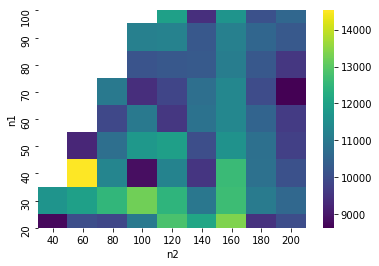

In [20]:
%matplotlib inline

import seaborn as sns


sns.heatmap(hm[::-1], cmap='viridis')

In [22]:
from backtesting.lib import plot_heatmaps


plot_heatmaps(heatmap, agg='mean')

Column(id='3124', ...)